# MELD Emotion Recognition Using Multimodal Deep Learning

This notebook implements emotion recognition on the MELD dataset using three approaches:
1. **LSTM Model** - Text-based emotion classification using pre-computed embeddings
2. **1D CNN Model** - Audio-based emotion classification using pre-computed audio embeddings
3. **Fusion Model** - Combined multimodal approach leveraging both text and audio

**Dataset:** MELD (Multimodal EmotionLines Dataset)
- Text embeddings: `MELD.Raw/text_emotion.pkl`
- Audio embeddings: `MELD.Raw/audio_emotion.pkl`
- Labels: `MELD.Raw/train_sent_emo.csv`, `dev_sent_emo.csv`, `test_sent_emo.csv`

## 1. Setup and Configuration

In [1]:
# Import necessary libraries
import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
import os
import warnings
warnings.filterwarnings('ignore')

# Scikit-learn imports
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import class_weight

# TensorFlow/Keras imports
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import (LSTM, Dense, Dropout, Conv2D,
                                      MaxPooling2D, Flatten, Input, 
                                      Concatenate, BatchNormalization)
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.utils import to_categorical

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

print(f"TensorFlow version: {tf.__version__}")
print(f"NumPy version: {np.__version__}")
print(f"Pandas version: {pd.__version__}")
print("✓ Libraries imported successfully!")

TensorFlow version: 2.20.0
NumPy version: 2.3.5
Pandas version: 2.3.3
✓ Libraries imported successfully!


## 2. Load and Prepare Data

In [2]:
# Load text and audio embeddings and labels from MELD dataset
print("Loading MELD data...")
print("=" * 70)

# Load text embeddings (pre-computed contextual features)
text_pkl_path = 'MELD.Raw/text_emotion.pkl'
if not os.path.exists(text_pkl_path):
    raise FileNotFoundError(f"Text embeddings not found at: {text_pkl_path}")

with open(text_pkl_path, 'rb') as f:
    text_data = pickle.load(f)

train_text_dict, val_text_dict, test_text_dict = text_data
print(f"✓ Text embeddings loaded: {len(train_text_dict)} train, {len(val_text_dict)} val, {len(test_text_dict)} test dialogues")

# Load audio embeddings (pre-computed contextual features)
audio_pkl_path = 'MELD.Raw/audio_emotion.pkl'
if not os.path.exists(audio_pkl_path):
    raise FileNotFoundError(f"Audio embeddings not found at: {audio_pkl_path}")

with open(audio_pkl_path, 'rb') as f:
    audio_data = pickle.load(f)

train_audio_dict, val_audio_dict, test_audio_dict = audio_data
print(f"✓ Audio embeddings loaded: {len(train_audio_dict)} train, {len(val_audio_dict)} val, {len(test_audio_dict)} test dialogues")

# Load labels from CSV files
base_path = 'MELD.Raw'
train_labels_df = pd.read_csv(os.path.join(base_path, 'train_sent_emo.csv'))
dev_labels_df = pd.read_csv(os.path.join(base_path, 'dev_sent_emo.csv'))
test_labels_df = pd.read_csv(os.path.join(base_path, 'test_sent_emo.csv'))

print(f"✓ Labels loaded: {len(train_labels_df)} train, {len(dev_labels_df)} val, {len(test_labels_df)} test utterances")

# Create label lookup dictionaries
def create_label_dict(df):
    """Create dictionary mapping (dialogue_id, utterance_id) -> emotion"""
    return {(row['Dialogue_ID'], row['Utterance_ID']): row['Emotion'] 
            for _, row in df.iterrows()}

train_label_dict = create_label_dict(train_labels_df)
val_label_dict = create_label_dict(dev_labels_df)
test_label_dict = create_label_dict(test_labels_df)

# Extract utterances with labels for both text and audio
def extract_utterances_with_labels(text_dict, audio_dict, label_dict):
    """Extract text and audio features with labels for valid utterances"""
    X_text_list, X_audio_list, y_list, dia_ids, utt_ids = [], [], [], [], []
    
    for dia_id in text_dict.keys():
        text_features = text_dict[dia_id]
        audio_features = audio_dict.get(dia_id)
        
        if audio_features is None:
            continue
            
        for utt_idx in range(text_features.shape[0]):
            if np.any(text_features[utt_idx]):  # Non-zero utterance
                key = (int(dia_id), utt_idx)
                if key in label_dict and utt_idx < audio_features.shape[0]:
                    X_text_list.append(text_features[utt_idx])
                    X_audio_list.append(audio_features[utt_idx])
                    y_list.append(label_dict[key])
                    dia_ids.append(dia_id)
                    utt_ids.append(utt_idx)
    
    return np.array(X_text_list), np.array(X_audio_list), y_list, dia_ids, utt_ids

print("\nExtracting text and audio utterances with labels...")
X_text_train, X_audio_train, train_emotions, train_dia_ids, train_utt_ids = extract_utterances_with_labels(
    train_text_dict, train_audio_dict, train_label_dict)
X_text_val, X_audio_val, val_emotions, val_dia_ids, val_utt_ids = extract_utterances_with_labels(
    val_text_dict, val_audio_dict, val_label_dict)
X_text_test, X_audio_test, test_emotions, test_dia_ids, test_utt_ids = extract_utterances_with_labels(
    test_text_dict, test_audio_dict, test_label_dict)

print(f"  Train: {len(X_text_train)} utterances")
print(f"  Val: {len(X_text_val)} utterances")
print(f"  Test: {len(X_text_test)} utterances")

# Encode labels
le = LabelEncoder()
all_emotions = train_emotions + val_emotions + test_emotions
le.fit(all_emotions)

y_train = le.transform(train_emotions)
y_val = le.transform(val_emotions)
y_test = le.transform(test_emotions)

num_classes = len(le.classes_)
print(f"\n✓ Labels encoded: {num_classes} emotion classes")
print(f"  Classes: {list(le.classes_)}")

# Convert to one-hot encoding
y_train_cat = to_categorical(y_train, num_classes=num_classes)
y_val_cat = to_categorical(y_val, num_classes=num_classes)
y_test_cat = to_categorical(y_test, num_classes=num_classes)

# Reshape text data for LSTM (samples, timesteps, features)
X_text_train = X_text_train.reshape(X_text_train.shape[0], 1, X_text_train.shape[1])
X_text_val = X_text_val.reshape(X_text_val.shape[0], 1, X_text_val.shape[1])
X_text_test = X_text_test.reshape(X_text_test.shape[0], 1, X_text_test.shape[1])

print(f"\n✓ Text data prepared for LSTM: {X_text_train.shape}")

# Reshape audio data for 1D CNN (samples, timesteps, features)
X_audio_train = X_audio_train.reshape(X_audio_train.shape[0], X_audio_train.shape[1], 1)
X_audio_val = X_audio_val.reshape(X_audio_val.shape[0], X_audio_val.shape[1], 1)
X_audio_test = X_audio_test.reshape(X_audio_test.shape[0], X_audio_test.shape[1], 1)

print(f"✓ Audio data prepared for 1D CNN: {X_audio_train.shape}")
print("=" * 70)

Loading MELD data...
✓ Text embeddings loaded: 1038 train, 114 val, 280 test dialogues
✓ Audio embeddings loaded: 1038 train, 114 val, 280 test dialogues
✓ Labels loaded: 9989 train, 1109 val, 2610 test utterances

Extracting text and audio utterances with labels...
  Train: 9989 utterances
  Val: 1109 utterances
  Test: 2610 utterances

✓ Labels encoded: 7 emotion classes
  Classes: [np.str_('anger'), np.str_('disgust'), np.str_('fear'), np.str_('joy'), np.str_('neutral'), np.str_('sadness'), np.str_('surprise')]

✓ Text data prepared for LSTM: (9989, 1, 600)
✓ Audio data prepared for 1D CNN: (9989, 300, 1)


## 3. LSTM Model (Text-Based Classification)

### 3.1 Build LSTM Model

In [3]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization
from tensorflow.keras.regularizers import l2

def build_lstm_model(input_shape, num_classes):
    """
    Build LSTM model with INCREASED REGULARIZATION to prevent overfitting.
    """
    model = Sequential(name='LSTM_Text_Model')
    
    # LSTM Layer 1: Added L2 Regularization & Increased Dropout to 0.5
    model.add(LSTM(128, return_sequences=True, input_shape=input_shape, 
                   kernel_regularizer=l2(0.001))) 
    model.add(Dropout(0.5)) # Increased from 0.3
    model.add(BatchNormalization())
    
    # LSTM Layer 2: Added L2 Regularization & Increased Dropout
    model.add(LSTM(64, return_sequences=False, kernel_regularizer=l2(0.001)))
    model.add(Dropout(0.5)) # Increased from 0.3
    model.add(BatchNormalization())
    
    # Dense Layer 1: Added L2 & Increased Dropout
    model.add(Dense(64, activation='relu', kernel_regularizer=l2(0.001)))
    model.add(Dropout(0.5)) # Increased from 0.3
    
    # Dense Layer 2: Added L2 & Increased Dropout
    model.add(Dense(32, activation='relu', kernel_regularizer=l2(0.001)))
    model.add(Dropout(0.5)) # Increased from 0.2
    
    # Output layer
    model.add(Dense(num_classes, activation='softmax'))
    
    return model

# Build the LSTM model
if 'X_text_train' in locals() and 'y_train_cat' in locals():
    # Use y_train_cat (one-hot encoded) to get num_classes dynamically
    num_classes = y_train_cat.shape[1] 
    lstm_input_shape = (X_text_train.shape[1], X_text_train.shape[2])
    
    lstm_model = build_lstm_model(lstm_input_shape, num_classes)

    print("LSTM Model Architecture (High Regularization):")
    lstm_model.summary()
else:
    print("❌ Data variables not found. Please run the data loading cells first.")

LSTM Model Architecture (High Regularization):


Model: "LSTM_Text_Model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 1, 128)         │       373,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 1, 128)         │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 7)              │           231 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 429,895 (1.64 MB)

 Trainable params: 429,511 (1.64 MB)

 Non-trainable params: 384 (1.50 KB)

### 3.2 Train LSTM Model

## 6. Train LSTM Model Independently

In [4]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

if 'lstm_model' in locals():
    # Compile LSTM model
    lstm_model.compile(
        optimizer='adam',
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    # Define callbacks
    lstm_callbacks = [
        EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True, verbose=1),
        ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-7, verbose=1),
        ModelCheckpoint('best_lstm_model.keras', monitor='val_accuracy', save_best_only=True, verbose=1)
    ]

    print("Training LSTM model...")
    print("=" * 70)

    # Train the model using one-hot encoded labels
    lstm_history = lstm_model.fit(
        X_text_train, y_train_cat,
        validation_data=(X_text_val, y_val_cat),
        epochs=100,
        batch_size=32,
        callbacks=lstm_callbacks,
        verbose=1
    )

    print("\n✓ LSTM model training complete!")
    if 'val_accuracy' in lstm_history.history:
        print(f"Best Validation Accuracy: {max(lstm_history.history['val_accuracy']):.4f}")
else:
    print("❌ Model not defined. Please run Block 1 first.")

Training LSTM model...
Epoch 1/100
311/313 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.3797 - loss: 2.4121
Epoch 1: val_accuracy improved from None to 0.53291, saving model to best_lstm_model.keras
313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.4674 - loss: 2.0624 - val_accuracy: 0.5329 - val_loss: 1.9586 - learning_rate: 0.0010
Epoch 2/100
310/313 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5518 - loss: 1.6889
Epoch 2: val_accuracy did not improve from 0.53291
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.5614 - loss: 1.6522 - val_accuracy: 0.5176 - val_loss: 1.7050 - learning_rate: 0.0010
Epoch 3/100
308/313 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5991 - loss: 1.5139
Epoch 3: val_accuracy improved from 0.53291 to 0.56087, saving model to best_lstm_model.keras
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.5952 - loss: 1.5099 - val_accuracy: 0.5609 - val_loss: 1.6450 - learning_rate: 0.0010
Epoch 4/100
307/313 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - ac

### 3.3 Visualize LSTM Training

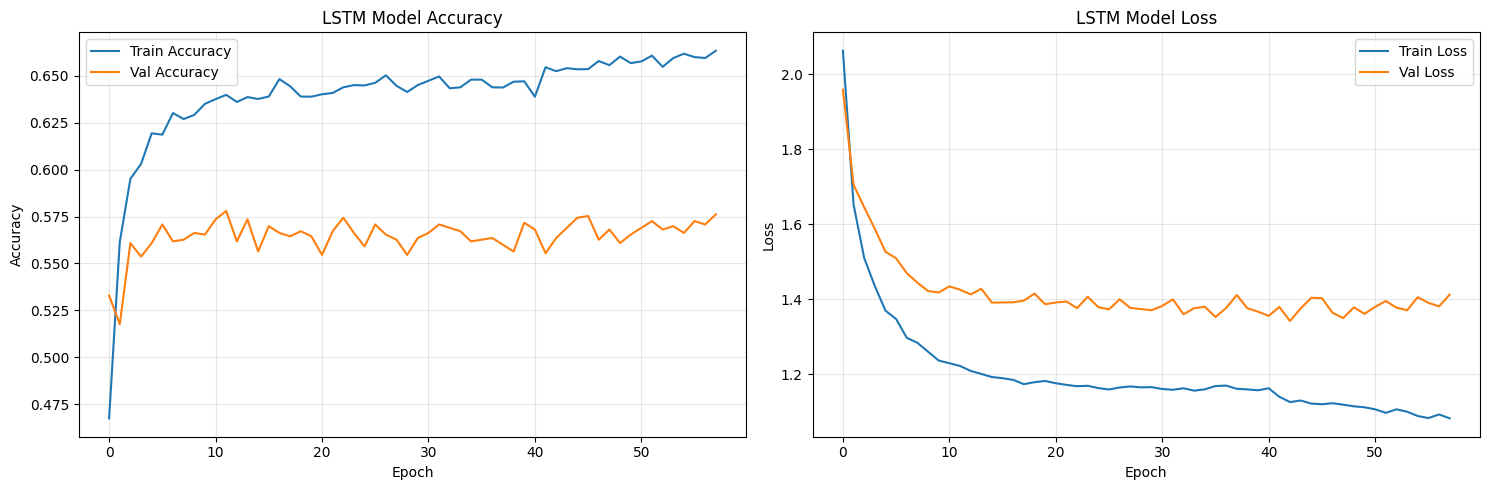

Final Training Accuracy: 0.6634
Final Validation Accuracy: 0.5762


In [5]:
# Plot LSTM training history
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Plot accuracy
axes[0].plot(lstm_history.history['accuracy'], label='Train Accuracy')
axes[0].plot(lstm_history.history['val_accuracy'], label='Val Accuracy')
axes[0].set_title('LSTM Model Accuracy')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Accuracy')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Plot loss
axes[1].plot(lstm_history.history['loss'], label='Train Loss')
axes[1].plot(lstm_history.history['val_loss'], label='Val Loss')
axes[1].set_title('LSTM Model Loss')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Loss')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"Final Training Accuracy: {lstm_history.history['accuracy'][-1]:.4f}")
print(f"Final Validation Accuracy: {lstm_history.history['val_accuracy'][-1]:.4f}")

### 3.4 Evaluate LSTM Model

LSTM Model Evaluation
Test Accuracy: 0.5858
Test Loss: 1.2697

Classification Report:
              precision    recall  f1-score   support

       anger       0.35      0.49      0.41       345
     disgust       0.00      0.00      0.00        68
        fear       0.00      0.00      0.00        50
         joy       0.56      0.44      0.49       402
     neutral       0.72      0.81      0.76      1256
     sadness       0.29      0.02      0.04       208
    surprise       0.42      0.56      0.48       281

    accuracy                           0.59      2610
   macro avg       0.33      0.33      0.31      2610
weighted avg       0.55      0.59      0.55      2610



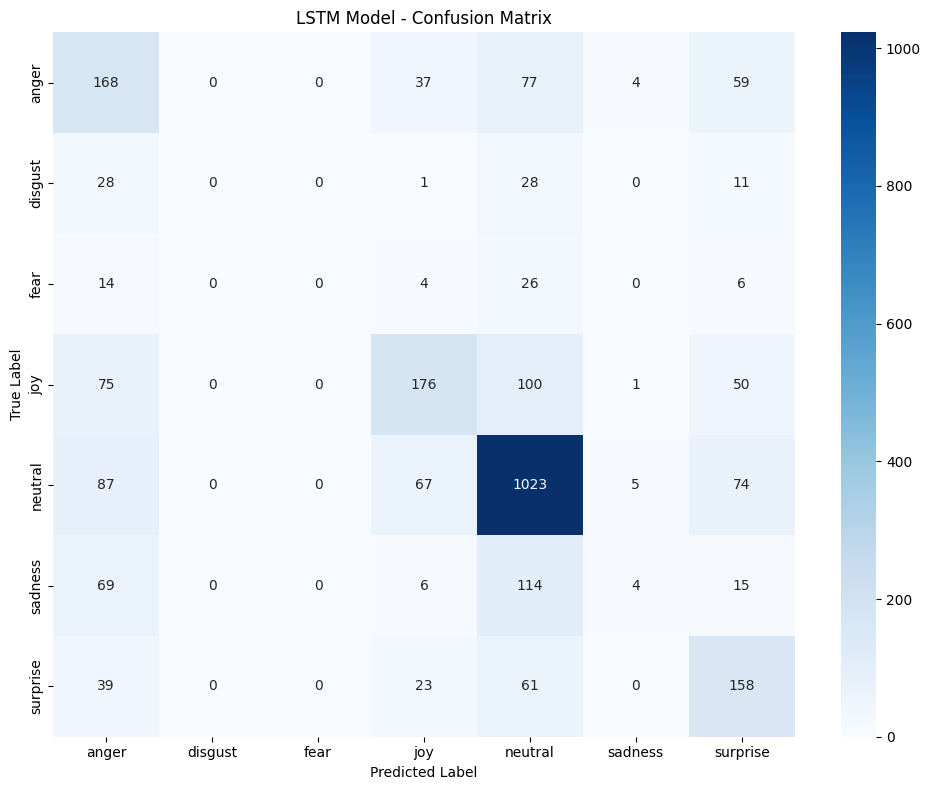

In [6]:
# Evaluate LSTM model on test set
print("LSTM Model Evaluation")
print("=" * 70)

# Get predictions
y_pred_probs = lstm_model.predict(X_text_test, verbose=0)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(y_test_cat, axis=1)

# Calculate test accuracy
test_loss, lstm_test_accuracy = lstm_model.evaluate(X_text_test, y_test_cat, verbose=0)
print(f"Test Accuracy: {lstm_test_accuracy:.4f}")
print(f"Test Loss: {test_loss:.4f}")

# Classification report
print(f"\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=le.classes_))

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.title('LSTM Model - Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.show()

## 4. CNN Model (Audio-Based Classification)

### 4.1 Build 1D CNN Model

In [7]:
from tensorflow.keras.layers import Conv1D, MaxPooling1D, GlobalAveragePooling1D

def build_1d_cnn_model(input_shape, num_classes):
    """
    Build 1D CNN for audio embedding-based emotion classification
    
    Args:
        input_shape: Shape of audio embedding input (timesteps, features)
        num_classes: Number of emotion classes
    
    Returns:
        Compiled Keras model
    """
    model = Sequential(name='CNN_Audio_Model')
    
    # Conv Block 1
    model.add(Conv1D(64, kernel_size=3, activation='relu', padding='same', input_shape=input_shape))
    model.add(BatchNormalization())
    model.add(MaxPooling1D(pool_size=2))
    model.add(Dropout(0.3))
    
    # Conv Block 2
    model.add(Conv1D(128, kernel_size=3, activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling1D(pool_size=2))
    model.add(Dropout(0.3))
    
    # Conv Block 3
    model.add(Conv1D(256, kernel_size=3, activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling1D(pool_size=2))
    model.add(Dropout(0.4))
    
    # Global pooling
    model.add(GlobalAveragePooling1D())
    
    # Dense layers
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.4))
    
    # Output layer
    model.add(Dense(num_classes, activation='softmax'))
    
    return model

# Build the 1D CNN model
cnn_input_shape = X_audio_train.shape[1:]
cnn_model = build_1d_cnn_model(cnn_input_shape, num_classes)

print("1D CNN Model Architecture:")
cnn_model.summary()

1D CNN Model Architecture:


Model: "CNN_Audio_Model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 300, 64)        │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 300, 64)        │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 150, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 150, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 150, 128)       │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 150, 128)       │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 75, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 75, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 75, 256)        │        98,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 75, 256)        │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_2 (MaxPooling1D)  │ (None, 37, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 37, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d        │ (None, 256)            │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 7)              │           455 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 166,919 (652.03 KB)

 Trainable params: 166,023 (648.53 KB)

 Non-trainable params: 896 (3.50 KB)

### 4.2 Train 1D CNN Model

In [8]:
# Re-compile to reset weights
cnn_model.compile(
    optimizer='adam', # Default LR is usually fine, or try Adam(learning_rate=0.001)
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Callbacks (Standard)
cnn_callbacks = [
    EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True, verbose=1),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1)
]

print("\n🚀 Training 1D CNN (No Class Weights)...")
print("=" * 70)

# Train WITHOUT class weights
cnn_history = cnn_model.fit(
    X_audio_train, y_train_cat,
    validation_data=(X_audio_val, y_val_cat),
    epochs=50,
    batch_size=32,
    callbacks=cnn_callbacks,
    # class_weight=class_weights_dict,  <-- REMOVED THIS
    verbose=1
)


🚀 Training 1D CNN (No Class Weights)...
Epoch 1/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 10s 24ms/step - accuracy: 0.4545 - loss: 1.6205 - val_accuracy: 0.4238 - val_loss: 2.0866 - learning_rate: 0.0010
Epoch 2/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 8s 24ms/step - accuracy: 0.4705 - loss: 1.5486 - val_accuracy: 0.4238 - val_loss: 1.6144 - learning_rate: 0.0010
Epoch 3/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 8s 25ms/step - accuracy: 0.4704 - loss: 1.5312 - val_accuracy: 0.4238 - val_loss: 1.5811 - learning_rate: 0.0010
Epoch 4/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 8s 25ms/step - accuracy: 0.4729 - loss: 1.5127 - val_accuracy: 0.4373 - val_loss: 1.5723 - learning_rate: 0.0010
Epoch 5/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 8s 26ms/step - accuracy: 0.4731 - loss: 1.5065 - val_accuracy: 0.4572 - val_loss: 1.5691 - learning_rate: 0.0010
Epoch 6/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 8s 26ms/step - accuracy: 0.4757 - loss: 1.4978 - val_accuracy: 0.4518 - val_loss: 1.5828 - learning_rate: 0.0010
Epoch 7/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 

### 4.3 Visualize 1D CNN Training

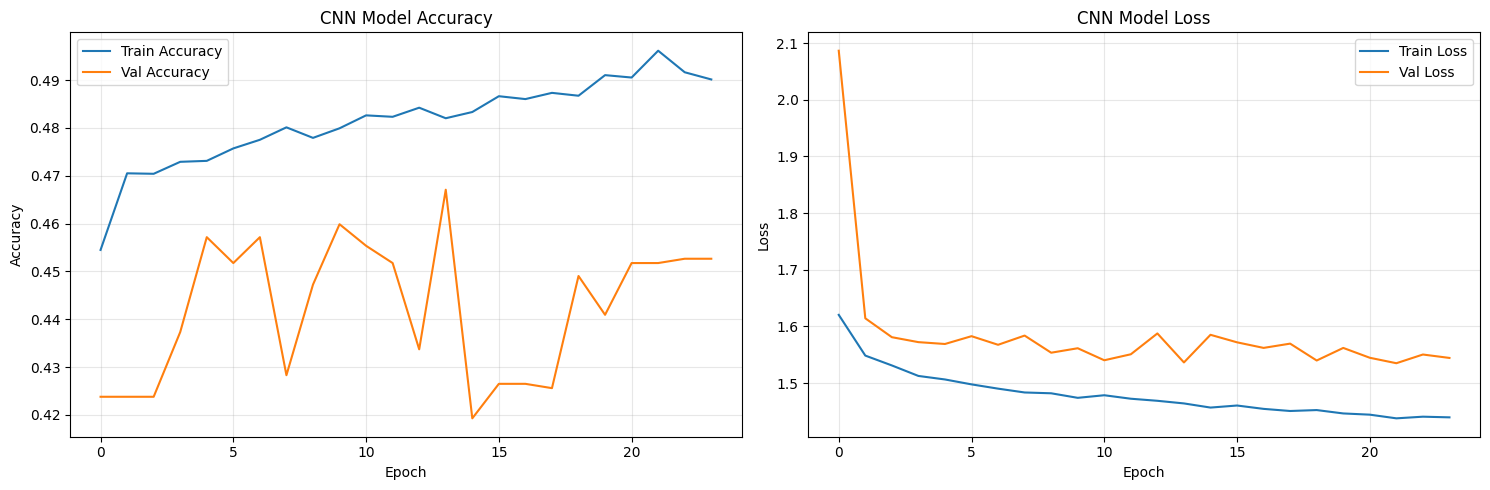

Final Training Accuracy: 0.4901
Final Validation Accuracy: 0.4527


In [9]:
# Plot CNN training history
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Plot accuracy
axes[0].plot(cnn_history.history['accuracy'], label='Train Accuracy')
axes[0].plot(cnn_history.history['val_accuracy'], label='Val Accuracy')
axes[0].set_title('CNN Model Accuracy')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Accuracy')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Plot loss
axes[1].plot(cnn_history.history['loss'], label='Train Loss')
axes[1].plot(cnn_history.history['val_loss'], label='Val Loss')
axes[1].set_title('CNN Model Loss')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Loss')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"Final Training Accuracy: {cnn_history.history['accuracy'][-1]:.4f}")
print(f"Final Validation Accuracy: {cnn_history.history['val_accuracy'][-1]:.4f}")

### 4.5 Evaluate CNN Model

CNN Model Evaluation
Test Accuracy: 0.4870
Test Loss: 1.4572

Classification Report:
              precision    recall  f1-score   support

       anger       0.28      0.28      0.28       345
     disgust       0.00      0.00      0.00        68
        fear       0.00      0.00      0.00        50
         joy       0.33      0.01      0.02       402
     neutral       0.53      0.91      0.67      1256
     sadness       0.00      0.00      0.00       208
    surprise       0.34      0.10      0.15       281

    accuracy                           0.49      2610
   macro avg       0.21      0.19      0.16      2610
weighted avg       0.38      0.49      0.38      2610



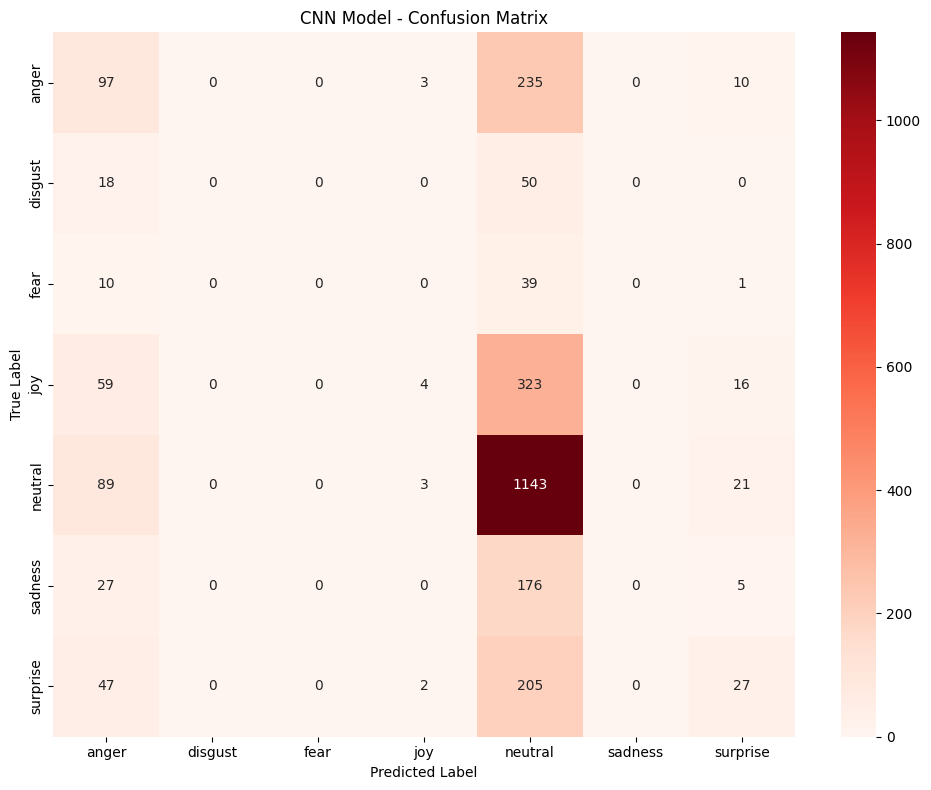

In [10]:
# Evaluate CNN model on test set
print("CNN Model Evaluation")
print("=" * 70)

# Get predictions
y_pred_probs = cnn_model.predict(X_audio_test, verbose=0)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(y_test_cat, axis=1)

# Calculate test accuracy
test_loss, cnn_test_accuracy = cnn_model.evaluate(X_audio_test, y_test_cat, verbose=0)
print(f"Test Accuracy: {cnn_test_accuracy:.4f}")
print(f"Test Loss: {test_loss:.4f}")

# Classification report
print(f"\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=le.classes_))

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Reds',
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.title('CNN Model - Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.show()

## 5. Fusion Model (Multimodal Text + Audio Classification)

### 5.1 Build Fusion Model

In [11]:
def build_fusion_model(text_input_shape, audio_input_shape, num_classes):
    """
    Build fusion model combining LSTM (text) and 1D CNN (audio) branches
    
    Args:
        text_input_shape: Shape of text input (timesteps, features)
        audio_input_shape: Shape of audio input (timesteps, features)
        num_classes: Number of emotion classes
    
    Returns:
        Compiled Keras model
    """
    # Text branch (LSTM)
    text_input = Input(shape=text_input_shape, name='text_input')
    text_lstm = LSTM(128, return_sequences=True)(text_input)
    text_lstm = Dropout(0.3)(text_lstm)
    text_lstm = BatchNormalization()(text_lstm)
    text_lstm = LSTM(64, return_sequences=False)(text_lstm)
    text_lstm = Dropout(0.3)(text_lstm)
    text_lstm = BatchNormalization()(text_lstm)
    text_dense = Dense(64, activation='relu')(text_lstm)
    text_dense = Dropout(0.3)(text_dense)
    
    # Audio branch (1D CNN)
    audio_input = Input(shape=audio_input_shape, name='audio_input')
    audio_conv = Conv1D(64, kernel_size=3, activation='relu', padding='same')(audio_input)
    audio_conv = BatchNormalization()(audio_conv)
    audio_conv = MaxPooling1D(pool_size=2)(audio_conv)
    audio_conv = Dropout(0.3)(audio_conv)
    
    audio_conv = Conv1D(128, kernel_size=3, activation='relu', padding='same')(audio_conv)
    audio_conv = BatchNormalization()(audio_conv)
    audio_conv = MaxPooling1D(pool_size=2)(audio_conv)
    audio_conv = Dropout(0.3)(audio_conv)
    
    audio_conv = Conv1D(256, kernel_size=3, activation='relu', padding='same')(audio_conv)
    audio_conv = BatchNormalization()(audio_conv)
    audio_conv = GlobalAveragePooling1D()(audio_conv)
    audio_conv = Dropout(0.4)(audio_conv)
    
    audio_dense = Dense(128, activation='relu')(audio_conv)
    audio_dense = Dropout(0.4)(audio_dense)
    audio_dense = Dense(64, activation='relu')(audio_dense)
    audio_dense = Dropout(0.3)(audio_dense)
    
    # Fusion: Concatenate both branches
    fusion = Concatenate()([text_dense, audio_dense])
    fusion = Dense(128, activation='relu')(fusion)
    fusion = Dropout(0.4)(fusion)
    fusion = BatchNormalization()(fusion)
    fusion = Dense(64, activation='relu')(fusion)
    fusion = Dropout(0.3)(fusion)
    
    # Output layer
    output = Dense(num_classes, activation='softmax', name='output')(fusion)
    
    # Create model
    model = Model(inputs=[text_input, audio_input], outputs=output, name='Fusion_Model')
    return model

# Build the fusion model
fusion_model = build_fusion_model(
    (X_text_train.shape[1], X_text_train.shape[2]),
    X_audio_train.shape[1:],
    num_classes
)

print("Fusion Model Architecture:")
fusion_model.summary()

Fusion Model Architecture:


Model: "Fusion_Model"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ audio_input         │ (None, 300, 1)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_3 (Conv1D)   │ (None, 300, 64)   │        256 │ audio_input[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 300, 64)   │        256 │ conv1d_3[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_3     │ (None, 150, 64)   │          0 │ batch_normalizat… │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_12          │ (None, 150, 64)   │          0 │ max_pooling1d_3[… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_4 (Conv1D)   │ (None, 150, 128)  │     24,704 │ dropout_12[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 150, 128)  │        512 │ conv1d_4[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_4     │ (None, 75, 128)   │          0 │ batch_normalizat… │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ text_input          │ (None, 1, 600)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_13          │ (None, 75, 128)   │          0 │ max_pooling1d_4[… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_2 (LSTM)       │ (None, 1, 128)    │    373,248 │ text_input[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_5 (Conv1D)   │ (None, 75, 256)   │     98,560 │ dropout_13[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_9 (Dropout) │ (None, 1, 128)    │          0 │ lstm_2[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 75, 256)   │      1,024 │ conv1d_5[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 1, 128)    │        512 │ dropout_9[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 256)       │          0 │ batch_normalizat… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_3 (LSTM)       │ (None, 64)        │     49,408 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_14          │ (None, 256)       │          0 │ global_average_p… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_10          │ (None, 64)        │          0 │ lstm_3[0][0]    

 Total params: 619,783 (2.36 MB)

 Trainable params: 618,247 (2.36 MB)

 Non-trainable params: 1,536 (6.00 KB)

### 5.2 Train Fusion Model

In [12]:
# Compile fusion model
fusion_model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Define callbacks
fusion_callbacks = [
    EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True, verbose=1),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-7, verbose=1),
    ModelCheckpoint('best_fusion_model.keras', monitor='val_accuracy', save_best_only=True, verbose=1)
]

print("Training Fusion model...")
print("=" * 70)

# Train the model with both text and audio inputs
fusion_history = fusion_model.fit(
    [X_text_train, X_audio_train], y_train_cat,
    validation_data=([X_text_val, X_audio_val], y_val_cat),
    epochs=100,
    batch_size=32,
    callbacks=fusion_callbacks,
    verbose=1
)

print("\n✓ Fusion model training complete!")
print(f"Best Validation Accuracy: {max(fusion_history.history['val_accuracy']):.4f}")

Training Fusion model...
Epoch 1/100
312/313 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.4284 - loss: 1.6910
Epoch 1: val_accuracy improved from None to 0.55275, saving model to best_fusion_model.keras
313/313 ━━━━━━━━━━━━━━━━━━━━ 13s 26ms/step - accuracy: 0.5290 - loss: 1.4167 - val_accuracy: 0.5528 - val_loss: 1.4106 - learning_rate: 0.0010
Epoch 2/100
312/313 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.6027 - loss: 1.1978
Epoch 2: val_accuracy did not improve from 0.55275
313/313 ━━━━━━━━━━━━━━━━━━━━ 9s 28ms/step - accuracy: 0.6124 - loss: 1.1818 - val_accuracy: 0.5365 - val_loss: 1.3455 - learning_rate: 0.0010
Epoch 3/100
312/313 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.6424 - loss: 1.1201
Epoch 3: val_accuracy improved from 0.55275 to 0.55726, saving model to best_fusion_model.keras
313/313 ━━━━━━━━━━━━━━━━━━━━ 9s 28ms/step - accuracy: 0.6397 - loss: 1.1239 - val_accuracy: 0.5573 - val_loss: 1.3273 - learning_rate: 0.0010
Epoch 4/100
312/313 ━━━━━━━━━━━━━━━━━━━━ 0s 

KeyboardInterrupt: 

### 5.3 Visualize Fusion Training

In [ ]:
# Plot Fusion model training history
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Plot accuracy
axes[0].plot(fusion_history.history['accuracy'], label='Train Accuracy')
axes[0].plot(fusion_history.history['val_accuracy'], label='Val Accuracy')
axes[0].set_title('Fusion Model Accuracy')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Accuracy')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Plot loss
axes[1].plot(fusion_history.history['loss'], label='Train Loss')
axes[1].plot(fusion_history.history['val_loss'], label='Val Loss')
axes[1].set_title('Fusion Model Loss')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Loss')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"Final Training Accuracy: {fusion_history.history['accuracy'][-1]:.4f}")
print(f"Final Validation Accuracy: {fusion_history.history['val_accuracy'][-1]:.4f}")

### 5.4 Evaluate Fusion Model

In [ ]:
# Evaluate fusion model on test set
print("Fusion Model Evaluation")
print("=" * 70)

# Get predictions
fusion_pred_probs = fusion_model.predict([X_text_test, X_audio_test], verbose=0)
fusion_pred = np.argmax(fusion_pred_probs, axis=1)
y_true = np.argmax(y_test_cat, axis=1)

# Calculate test accuracy
fusion_test_loss, fusion_test_accuracy = fusion_model.evaluate(
    [X_text_test, X_audio_test], y_test_cat, verbose=0
)
print(f"Test Accuracy: {fusion_test_accuracy:.4f}")
print(f"Test Loss: {fusion_test_loss:.4f}")

# Classification report
print(f"\nClassification Report:")
print(classification_report(y_true, fusion_pred, target_names=le.classes_))

# Confusion matrix
cm = confusion_matrix(y_true, fusion_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens',
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.title('Fusion Model - Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.show()

### 5.5 Compare All Models

In [ ]:
# Compare all three models
print("MODEL COMPARISON")
print("=" * 70)

models_comparison = pd.DataFrame({
    'Model': ['LSTM (Text Only)', 'CNN (Audio Only)', 'Fusion (Text + Audio)'],
    'Test Accuracy': [lstm_test_accuracy, cnn_test_accuracy, fusion_test_accuracy]
})

print(models_comparison.to_string(index=False))

# Visualize comparison
plt.figure(figsize=(10, 6))
bars = plt.bar(models_comparison['Model'], models_comparison['Test Accuracy'],
               color=['#3498db', '#e74c3c', '#2ecc71'])
plt.ylabel('Test Accuracy')
plt.title('Model Performance Comparison')
plt.ylim(0, 1.0)
plt.xticks(rotation=15, ha='right')

# Add value labels on bars
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{height:.4f}',
             ha='center', va='bottom')

plt.grid(True, alpha=0.3, axis='y')
plt.tight_layout()
plt.show()

# Calculate improvement
improvement_over_lstm = ((fusion_test_accuracy - lstm_test_accuracy) / lstm_test_accuracy) * 100
improvement_over_cnn = ((fusion_test_accuracy - cnn_test_accuracy) / cnn_test_accuracy) * 100

print(f"\nFusion Model Improvements:")
print(f"  Over LSTM: {improvement_over_lstm:+.2f}%")
print(f"  Over CNN: {improvement_over_cnn:+.2f}%")

In [ ]:
# Per-class performance analysis
from sklearn.metrics import precision_recall_fscore_support

print("PER-CLASS PERFORMANCE ANALYSIS")
print("=" * 70)

# Get predictions for all models
lstm_pred = np.argmax(lstm_model.predict(X_text_test, verbose=0), axis=1)
cnn_pred = np.argmax(cnn_model.predict(X_audio_test, verbose=0), axis=1)
fusion_pred = np.argmax(fusion_model.predict([X_text_test, X_audio_test], verbose=0), axis=1)
y_true = np.argmax(y_test_cat, axis=1)

# Calculate F1 scores
lstm_precision, lstm_recall, lstm_f1, _ = precision_recall_fscore_support(
    y_true, lstm_pred, average=None, labels=range(num_classes)
)
cnn_precision, cnn_recall, cnn_f1, _ = precision_recall_fscore_support(
    y_true, cnn_pred, average=None, labels=range(num_classes)
)
fusion_precision, fusion_recall, fusion_f1, _ = precision_recall_fscore_support(
    y_true, fusion_pred, average=None, labels=range(num_classes)
)

# Create comparison dataframe
per_class_df = pd.DataFrame({
    'Emotion': le.classes_,
    'LSTM F1': lstm_f1,
    'CNN F1': cnn_f1,
    'Fusion F1': fusion_f1,
    'Improvement': fusion_f1 - np.maximum(lstm_f1, cnn_f1)
})

print("\nF1-Score Comparison by Emotion Class:")
print(per_class_df.to_string(index=False))

# Visualize per-class F1 scores
fig, ax = plt.subplots(figsize=(12, 6))
x = np.arange(len(le.classes_))
width = 0.25

bars1 = ax.bar(x - width, lstm_f1, width, label='LSTM', color='#3498db')
bars2 = ax.bar(x, cnn_f1, width, label='CNN', color='#e74c3c')
bars3 = ax.bar(x + width, fusion_f1, width, label='Fusion', color='#2ecc71')

ax.set_xlabel('Emotion Class')
ax.set_ylabel('F1-Score')
ax.set_title('Per-Class F1-Score Comparison')
ax.set_xticks(x)
ax.set_xticklabels(le.classes_, rotation=45, ha='right')
ax.legend()
ax.grid(True, alpha=0.3, axis='y')
plt.tight_layout()
plt.show()

print(f"\nEmotions with highest fusion improvement:")
top_improvements = per_class_df.nlargest(3, 'Improvement')
for _, row in top_improvements.iterrows():
    print(f"  {row['Emotion']}: +{row['Improvement']:.4f}")